# Crime Prediction Using KDE, Weather and Demographics 
Authors: Xiaoyu He, Haopeng Wang, Changkai Zhou

## Introduction

**Crime Prediction** is a popular and challenging topic in the research. The nature of crime incidents includes significant randomness, which makes it extreme difficult for prediction. A lot of factors are relevant to the occurrence of crime incidents and numerous paper has made contribution to the topic.

Short-term prediction of crime is a tougher problem to solve. Inspired by the research of Almanie, Mirza and Lor (2015) [1], we tried to evaluate the effects of weather and demographics using logistic regression. Our work includes:
    1. Using the method of Kernel Density Estimation to describe the spacial and temperal distribution of crime incidents.
    2. Involving the features of weather and demographics as efforts to explain about crime incidents.
    3. Using logistic regression to predict the occurrence of crime incidents within specific areas in a short period.
    4. Evaluating the model with real crime datasets in Chicago.

In the end, we achieved at the similar level of prediction accuracy as Almanie, Mirza and Lor (2015) achieved in the paper. In addition, KDE and demographics are found effective in the predicton while the features of weather contribute nearly nothing to the model.

[1] Almanie, T., Mirza, R. and Lor, E. (2015). Crime Prediction Based on Crime Types and Using Spatial and Temporal Criminal Hotspots. International Journal of Data Mining & Knowledge Management Process, 5(4), pp.01-19.

## Project Content
* Introduction
* Data Collection
    * Crime Data  
    * Weather data   
    * Demographic data  
* Methodology
    * Feature Selection 
    * Logistic Regression 
    * Evaluation 
* Implementation
    * Data Preparation
    * Model Fitting
    * Evaluation
* Results Analysis
    * Analysis
    * Interesting Findings

# 1. Data Collection

## 1.1 Crime Data

### Raw Crime Data Collection

Chicago criminal data was collected from city of [Chicago data portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), we can access detailed up-to-date criminal records since 2001, and currently there are more than 6 million records available there.

The data portal provides SODA API for data export, this is the [endpoint](https://data.cityofchicago.org/resource/6zsd-86xi.json). We downloaded the data in the batch size of 1000 and 1 second interval between API requests. Eventually we have first 1 million records from the portal. The data exported from API is in JSON format, we used Pandas library to read the JSON data into Dateframe, and then saved the data into CSV files. 

We wrote the function `save_chicago_crime_data` to download the chicago crime data.

*Note: Now, we didn't seperate different crime type. We will consider differentiate crime type in the future predicting model. *

In [7]:
import pandas as pd
from datetime import datetime
from weather import *
from demographic import *

from kde import *
from KDE_pre_computation import *
from KDE_visualization import *
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# run this if don't have processed CSV from Google Drive
save_chicago_crime_data('2013', offset=0)
save_chicago_crime_data('2014', offset=0)
save_chicago_crime_data('2015', offset=0)

We used `merge_sort_and_remove_duplicate()` function to sort the saved data by occurance date time. 

In [8]:
# run this if don't have processed CSV from Google Drive
merge_sort_and_remove_duplicate(2013)
merge_sort_and_remove_duplicate(2014)
merge_sort_and_remove_duplicate(2015)

In [ ]:
# # Global dataframes
df_2013 = pd.read_csv('data/chicago_crime_data_2013_sorted.csv')
df_2014 = pd.read_csv('data/chicago_crime_data_2014_sorted.csv')
df_2015 = pd.read_csv('data/chicago_crime_data_2015_sorted.csv')

# # set date column to dtype of datetime
df_2013['date'] = pd.to_datetime(df_2013['date'])
df_2014['date'] = pd.to_datetime(df_2014['date'])
df_2015['date'] = pd.to_datetime(df_2015['date'])

Then we used `split_dataframe()` to split the data into hours interval.

In [26]:
# # Global split dfs
df_2013_split = split_dataframe(df_2013, 2013, hours_interval=6)
df_2014_split = split_dataframe(df_2014, 2014, hours_interval=6)
df_2015_split = split_dataframe(df_2015, 2015, hours_interval=6)

### Data Zoning

We splited the Chicago community area into 25 by 25 blocks, and pre-computed the block yearly KDE, every 6 hours interval KDE, yearly crime counts and every 6 hours crime counts.

In [10]:
# Global: northwest corner and southeast corner ([latitude, longitude])
chicago_bounding_box = [[42.025339, -87.950502], [41.633514, -87.515073]]

For the convenience of KDE and crime counts data pre-computation, we split the bounding box into 25 by 25 blocks.

### Pre-Compute KDE data

We used Kernel Density Estimation (KDE) to find density spots of criminal incidents. We used `gaussian_kde()` function in stats package of Scipy library to generates a KDE using Gaussian kernels, which works for both uni-variate and multi-variate data. It also includes automatic bandwidth determination, which makes it very convenient to use.

First, we extract the criminal incidents location coordinates from the data we collected in some time periods. Then, we convert the latitude and longitude into a 2D ndarray then feed to `gaussian_kde()` function. The result can be visualized using matplotlib library with the boundaries of Chicago neighborhood.

In [4]:
from scipy import stats

def compute_Gaussian_KDE(data1, data2):
    values = np.vstack([data1, data2])
    return stats.gaussian_kde(values)

In [27]:
# Global yearly kernel, NOTE:longitude first
kernel_2013 = compute_Gaussian_KDE(df_2013['longitude'], df_2013['latitude'])
kernel_2014 = compute_Gaussian_KDE(df_2014['longitude'], df_2014['latitude'])
kernel_2015 = compute_Gaussian_KDE(df_2015['longitude'], df_2015['latitude'])

In [ ]:
# Global hours interval kernel list, NOTE:longitude first
kernel_2013_intervals = [compute_Gaussian_KDE(df['longitude'], df['latitude']) for df in df_2013_split]
kernel_2014_intervals = [compute_Gaussian_KDE(df['longitude'], df['latitude']) for df in df_2014_split]
kernel_2015_intervals = [compute_Gaussian_KDE(df['longitude'], df['latitude']) for df in df_2015_split]

We used `save_intervals_KDE_to_file()` and `save_yearly_KDE_to_file()` to save KDE to file. Then we used `read_saved_interval_KDE()` and `read_yearly_KDE()` to read the saved file and create global variables to feed into KED API call. We also created API function `read_saved_yearly_KDE()` and `read_saved_interval_KDE()` to get KDE data for modele training. 

### Pre-Compute Crime Counts

We used `crime_counts_yearly()` and `crime_counts()` to prepare the yearly crime counts and hours interval crime counts data. The code below shows this process:

In [152]:
crime_counts_yearly(df_2013, 2013, block_lat=25, block_lon=25)
crime_counts_yearly(df_2014, 2014, block_lat=25, block_lon=25)
crime_counts_yearly(df_2015, 2015, block_lat=25, block_lon=25)

In [ ]:
crime_counts(df_2013_split, 2013, block_lat=25, block_lon=25)
crime_counts(df_2014_split, 2014, block_lat=25, block_lon=25)
crime_counts(df_2015_split, 2015, block_lat=25, block_lon=25)

### API for KDE data
Finally, after extracing and reading all the KDE data, we provide some API for getting the KDE data. 

In [7]:
def __read_KDE(kernel, latitude, longitude):
    '''
    Read single point KDE out of given kernel object
    '''
    return kernel([[latitude], [longitude]])[0]

We provide several API function:
* `get_interval_KDE()` get interval KDE
* `get_yearly_KDE()` get yearly KDE.
* `get_crime_count() ` API for get crime count.
* `get_yearly_crime_count` API for get yearly crime count

To compute the block KDE, we pick five sample points, use the averge KDE of these five points to represent this block's KDE.

In [ ]:
def __generate_samples(nw_corner, se_corner):
    ''' 
    Get 5 points:
    ---------
    | +   + |
    |   +   |
    | +   + |
    ---------
    '''
    latitude_diff_fourth = (se_corner[0] - nw_corner[0])/4
    longtitude_diff_fourth = (se_corner[1] - nw_corner[1])/4
    
    sample_nw = [nw_corner[0]+latitude_diff_fourth, nw_corner[1]+longtitude_diff_fourth]
    sample_ne = [se_corner[0]-latitude_diff_fourth, sample_nw[1]]
    sample_mid = [sample_nw[0]+latitude_diff_fourth, sample_nw[1]+longtitude_diff_fourth]
    sample_sw = [sample_nw[0], se_corner[1]-longtitude_diff_fourth]
    sample_se = [sample_mid[0]+latitude_diff_fourth, sample_mid[1]+longtitude_diff_fourth]
    
    return (sample_nw, sample_ne, sample_mid, sample_sw, sample_se)

## visualize_KDE

This is the visualization of out KDE output.

In [ ]:
df_2015 = pd.read_csv('data/chicago_crime_data_2015_sorted.csv')
df_2015['date'] = pd.to_datetime(df_2015['date'])
kernel_2015 = compute_Gaussian_KDE(df_2015['longitude'], df_2015['latitude'])

visualize_KDE(kernel_2015, df_2015['longitude'], df_2015['latitude'])

<div id="mainDiv">
    <div id="ddd" style='width:40%;float:left;margin:5%'>
    <img src="https://lh3.googleusercontent.com/MKUgKPiXqoOR3EinPBy72O2naszlPDuOnvr2cnBaLhsXJe5meeqYdfIjW7GLSNBjPdjnLqBxKSqN6h67GtAHAEsRoyX3GrW_aPF-Z2CaUopYLpyy681-x9VJ3d73MdyfoIGfyiyzuYxQBe3eN73_Fy6Gbeuzf2HYJsHZLyUOm5Q3Rt8S6Tfn15RL41JXqU4nhDkh2wKf40VWVYmYTFrMJZRfLX9gjuc3Ns9EJ0lUvdVziTrHcwOshocBZAv17FMoQlK-1H-TKa0QMNis7cByHA3eU8sHKqPh5u7TrZk4OC94dsBbEegrHji0_OTQGkcYoa534peG_Zh5fhOPu-Y9TQNM01WOHCazeQVoU20DpUPleJurD_iMAUEPSqL-oGwLEWuM6ao3faRYvSqzLJlVkvMe6TvO0kXVjmJCPvyCG6q9ZzKoRip0SSTyzMk1UMu85qZ-K6VwJMIVTjzULXi6D4LzjJgj8S9GwRM6JT12YMgsNimiVEc0vjKY9ASpH27kprj-RmgMy-xzxmIVvmTkRc2esPSi3CWdhDLne0R3NmFhLKVIQOioTFRFhycQKtUwhy7j4ITohknubJAT5fSWrO5fqBk_Wi9YMbNKum4ZD19fRS9Ba5oCqDo5O8zMbIg7dSPyxBX4tw5rb_pxpuKFtLhIHrsLQ8Lgnzou3LVDIQ=w1005-h922-no">
    </div>
</div>


## 1.2 Weather Data

Several paper have shown that temperature has a strong positive effect on crime rate. Here we download a 30 year panel of daily crime and weather data of Chicago. 

The Chicago weather data is download from this source: [ghcn-daily](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/). The original file that we download is `ghcnd_all.tar.gz` which contains historical data for 98,814 weather station in the world. This is file is 3GB, containing 98,814 items.

Firstly, we identified 34 weather station in Chicago using `ghcnd-stations.txt`. Secondly, by looking at the `ghcnd-inventory.txt`, we selected station containing data from 1980 to 2006. 

In [1]:
with open('ghcn-daily/data/ghcnd-inventory_chicago.txt') as afile:
    for line in afile:
        data = [item for item in line.strip().split(' ') if item]
        if data[3] == 'TMAX' and int(data[4]) <= 1980 and int(data[5]) >= 2006:
            print data

['USC00111577', '41.7372', '-87.7775', 'TMAX', '1928', '2016']
['USW00094846', '41.9950', '-87.9336', 'TMAX', '1958', '2016']


As you can see from the above list, we can use the data from weather station `USC00111577` and `USW00094846`.

The northwest corner and southeast corner of chicago is [42.025339, -87.950502], [41.633514, -87.515073]. After some observations, we selected `CHICAGO MIDWAY AP 3SW`, with station id `USC00111577`.


### Parsing `.dly` file
The daily climatological data we download from the Global Historical Climatology Network (GHCN) is provided in `.dly` format. "Each `.dly` file contains data for one station.  The name of the file corresponds to a station's identification code. Each record in a file contains one month of daily data." (cited from the readme.txt of GHCN). For example, `USC00026481.dly` contains the data for the station with the identification code USC00026481). 

We developed `readDly(data)` function to parse the `.dly` file. 

After parsing the `.dly` file, we used `get_attribute(attriName)` function to extracted the desired weather attribute and stored it in `extracted_data` folder. 

We extracted the following attributes:

* TMAX = Daily max temperature
* TMIN = Daily min temperature
* PRCP = Precipitation (tenths of mm)
* AWND = Average daily wind speed (tenths of meters per second)
* TSUN = Daily total sunshine (minutes)
* 01 = Fog, ice fog, or freezing fog (may include heavy fog)
* 16 = Rain (may include freezing rain, drizzle, and freezing drizzle) 
* 18 = Snow, snow pellets, snow grains, or ice crystals

The description of these attributes comes from the readme.txt of GHCN file in `ghcnd_all.tar.gz`.

### API for the weather data

After extract the useful data in to files, we developed a API to get the weather data. 
The weather data we used are: max temp, min temp, avg temp, precipitation, average daily wind speed , fog, rain, snow.

The most highest level of API and it's signature is shown below:

In [3]:
def get_weather(wdf, datetime):
    '''
    To get the weather data for the specified date
    Input:
        df: the weather dataFrame
        date: a datetime object 'YYYY-MM-DD' format
    Return:
        1D numpy array, corresponding to
        ['TMAX', 'TMIN', 'TMIN', 'PRCP', 'AWND', 'Fog', 'Rain', 'Snow']
    '''
    return wdf.loc[datetime].value

Following code demonstrates the simple usage of this API.

In [6]:
wdf = load_weather()
print wdf.columns
print get_weather(wdf, datetime(2015,10,1))

Index([u'TMAX', u'TMIN', 0, u'PRCP', u'AWND', u'WT01', u'WT16', u'WT18'], dtype='object')
[ 150.   111.   130.5    0.    81.     0.     0.     0. ]
[ 156.  106.  131.    0.   85.    0.    0.    0.]
[ 122.    89.   105.5    3.    76.     1.     0.     0. ]
[ 139.   100.   119.5    0.    51.     0.     0.     0. ]


## 1.3 Demographic Data

In addition to weather data, we also collected [demographics data](https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2/data) of Chicago. 

This dataset contains six demographics features, collected in 2008-2012. Since demographic data changes very slow, we will use this data for the crime prediction in 2013-2014 year. The indicators are 

* 'percent of housing crowded': the percent of occupied housing units with more than one person per room
* 'percent households below poverty': the percent of households living below the federal poverty level
* 'percent aged 16+ unemployed': the percent of persons in the labor force over the age of 16 years that are unemployed
* 'percent aged 25+ without high school diploma': the percent of persons over the age of 25 years without a high school diploma
* 'percent aged under 18 or over 64': the percent of the population under 18 or over 64 years of age
* 'per capita income ': per capita income

The description of these attributes comes from the official desciption of this dataset.[2]

[2] Selected socioeconomic indicators in Chicago, 2008 – 2012. (2014). 1st ed. [ebook] Chicago: Chicago Department of Public Health. Available at:[link]( https://data.cityofchicago.org/api/views/fwb8-6aw5/files/A5KBlegGR2nWI1jgP6pjJl32CTPwPbkl9KU3FxlZk-A?download=true&filename=P:%5CEPI%5COEPHI%5CMATERIALS%5CREFERENCES%5CECONOMIC_INDICATORS%5CDataset_Description_socioeconomic_indicators_2012_FOR_PORTAL_ONLY.pdf) [Accessed 9 Dec. 2016].

### Parsing the data to fit KDE model

The original demographic data does not have GPS coordinate, but only have community name and community number. However, in KDE, we've divided Chicago into 25x25 block. In order to fit this demographic data into our KDE model, we downloaded the GPS coordinates of community boundries points from [cityofchicago website](https://www.cityofchicago.org/city/en/depts/doit/dataset/boundaries_-_communityareas.html).
Then, for each KDE block, we assigned it with a community number, and corresponding data.

First, we used `generate_demographic_pickle_file()` function processed the demographic data and stored it in a pickle file for later model training. Then, we can use `read_demographic_data()` function to read the demographic data.

### API for reading the demographic data
The following code demonstrate how to read the data.

In [5]:
# Generate pickle file, assume we are in the same directory of demographic_data folder
generate_demographic_pickle_file()

# Read the normalized demographic data
demographic_dict = read_demographic_data('demographic.pkl')

# Get the demographic data columns
demographic_cols = demographic_dict.keys()

### Verify and visualize the demographic data

Before adding the demographic data into our KDE model, we visualized the data in the map. Thus, we can ensure that we have processed the data correctly. 

demographic columns:
['PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED', 'PER CAPITA INCOME ', 'PERCENT AGED UNDER 18 OR OVER 64', 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 'PERCENT OF HOUSING CROWDED']


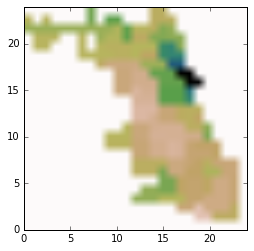

In [3]:
# For verification, print some data
print 'demographic columns:\n', demographic_cols
assert demographic_dict['PERCENT OF HOUSING CROWDED'].shape == (25, 25)

# Plot the data
visualize_demographic(demographic_dict['PER CAPITA INCOME '])

# 2. Methodology

## 2.1 Feature Selection

Selected features includes:
* **Long-Term KDE**
* **Short-Term KDE**
* **Weather**
* **Demographics**
* **Time of Day**

#### Spatial / Temperal
* Spatial Features: long-term KDE, short-term KDE, demographics
* Temperal Features: Short-Term KDE, weather, time of day

#### Long-Term / Short-Term
* Long-Term: long-term KDE, social-economics
* Short-Term: Short-Term KDE, weather, time of day

As is shown above, the features we considered reflect the factors behind crime incidents from different perspectives. Our features can be classified in these two dimensions.

We tried different combinenations of input features as below and compared their performance: 

* Baseline that only have KDE feature
* KDE feature with demographics
* KDE feature with weather
* KDE feature with temperature and demographics
* Temperature and demographics without KDE feature

PS: all with the feature of Time of Day.

## 2.2 Logistic Regression

We used logistic regression in our model. We encoded our data into 21 input features, and we interpret the output of logistic regression as the probability that a crime would happened at given time and area. 


\begin{align*}
Loss(\frac{p[y_{t+1}(p)=1]}{1-p[y_{t+1}(p)=1]})  & = \beta_0  \\
 & + \beta_1 KDE_{short-term} + \beta_1 KDE_{yearly} \\
 & + \Sigma_{i=2}^9 \beta_i Weather_i \\
 & + \Sigma_{i=10}^{15} \beta_i Demographic_i\\
 & + \Sigma_{i=16}^{21} \beta_i DateTime_i
\end{align*}

|Attributes| Details |
|---|---|
|$y_{t+1}(p)$ |the occurrence of crime in a block during period of t+1 (1=yes, 0=no)|
|$KDE_{short-term}$ |6hs interval   |  
|$Weather_i$| daily temperature max, min, avg, precipitation, wind speed, fog, rain, snow  |   
|$Demographic_i$| unemployment rate, income per capita, education level etc.  |
|$Datetime_i$| Timeslot in day, flag of weekday or weekend |   

Basicly, we have 2 KDE features, 8 weather features, 6 demographic features and 6 datetime features.

## 2.3 Evaluation

We used ** ROC curves and AUC value** to evaluate the performance of our model, which is a common method of evaluation in logistic regression. 

> An ROC curve is a commonly used way to visualize the performance of a binary classifier, meaning a classifier with two possible output classes. [3](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

> AUC is an abbrevation for area under the curve. It is used in classification analysis in order to determine which of the used models predicts the classes best. An example of its application are ROC curves. Here, the true positive rates are plotted against false positive rates. [4](http://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it)

Here we provide a more detailed explanation of the concepts: [ROC curves and Area Under the Curve(AUC) explained (video)](http://www.dataschool.io/roc-curves-and-auc-explained/)

Finally, we will summarized our model performance by a ROC plot and AUC. Here is a quick explaination of ROC and AUC:


# 3. Implementation

Here are some details below:
* We divided Chicago into 25\*25 blocks (1000m\*1000m) to predict separately.
* We divided time into 6-hour time slots, that is to say, one day including four time slots
* We used Python's sklearn to implement logistic regression.
* Data Range:
    * Crime Data & Weather: 
        * Train Dataset: 06/01/2015 - 09/01/2015
        * Test Dataset: 09/01/2015 - 10/01/2015
    * Demographics: use 2008-2012 to replace 2015
    
We took several controlled experiments and tried to prove evaluate the model and how each kind of features affect the prediction. 

In [ ]:
from model import logistic_regression, cal_auc_results, cal_one_auc_result, cross_val_score, get_data, get_data_baseline, plot_ROC_curve, plot_auc_results, plot_prob, plot_two_ROC_curve, prepare_data, prepare_data_baseline, roc_curve
import time
from datetime import datetime

### 1. Data Preparation

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [ ]:
# Example
start = time.time()

dt_train_start = datetime(2015,6,1,0,0,0)
dt_train_end = datetime(2015,9,1,0,0,0)
dt_test_start = datetime(2015,9,1,0,0,0)
dt_test_end = datetime(2015,10,1,0,0,0)

X_train, X_test, y_train, y_test = prepare_data\
        (wdf, dt_train_start, dt_train_end, dt_test_start, dt_test_end,\
         [42.025339, -87.950502], [41.633514, -87.515073], 6)

In [ ]:
dt_train_base_start = datetime(2015,6,1,0,0,0)
dt_train_base_end = datetime(2015,9,1,0,0,0)
dt_test_base_start = datetime(2015,9,1,0,0,0)
dt_test_base_end = datetime(2015,10,1,0,0,0)

X_train_base, X_test_base, y_train_base, y_test_base = prepare_data_baseline\
        (wdf, dt_train_base_start, dt_train_base_end, dt_test_base_start, dt_test_base_end,\
         [42.025339, -87.950502], [41.633514, -87.515073], 6)

### 2. Model Fitting

In [ ]:
P_train, P_test = logistic_regression(X_train, X_test, y_train,  y_test)
P_train_base, P_test_base = logistic_regression(X_train_base, X_test_base, y_train_base, y_test_base)

### 3. Evaluation 
Plot the ROC curves to evaluate the model.

#### KDE + Other Features

In [ ]:
# roc_auc, x_trans, y_trans = cal_one_auc_result(P_train, y_train)
roc_auc, x_trans, y_trans = cal_one_auc_result(P_test, y_test)
plot_ROC_curve(x_trans, y_trans, roc_auc)

#### KDE Baseline

In [158]:
roc_auc_base, x_trans_base, y_trans_base = cal_one_auc_result(P_train_base, y_train_base)
plot_ROC_curve(x_trans_base, y_trans_base, roc_auc_base)

In [ ]:
plot_two_ROC_curve(x_trans, y_trans, x_trans_base, y_trans_base, roc_auc, roc_auc_base)

# 4. Results Analysis

## 4.1 Analysis

###  KDE + Weather + Demographics > KDE 

**Our model** **performs better** with KDE, weather and demographic features than the one with only the KDE to predict the crime incidents.

![roc-all](https://lh3.googleusercontent.com/7t0iwMdHT648Vdel562d-5Fu4JN-ZRwx9m9CzRQBseb-aQtK_PvPcajf-izZfwDsVcNVCLkDweHw4bvHeYv9aO6KG1LyyvKyrgOju8VQSSkRqQo-5PXlSV61HDqcOyBMHtq_wQwYYnjnloiNLmPTs1yzbG9aUOg_Z1kgry9C17RL7ZiptdEUvYaRJq7LIKAyXtSEZnTh8AVZY9orHoyP9PbzStqYnxHGvV8QQr8a09-qi3O2QJ-7huY-Hr6rCU5-HEK6_M1BAWVz_Zx5METaIJ0SJQCm-A4vzgs9fF3eB1D3Nzva3opFk_QsRgmgrLkODbhyCm752t2ZEtInh9E4BTHfRguLi7XwgLjNAWC-KHnPUuEbIvjhLbZQYI8yIs5FRfXIT2Tf9kaHtuTbRTlmftmZQzgPtb3XYr_9EPlwEaUFaK3_tIAETp9BpOE1xZZ8eE7UFqMRHc8YRi8098Ac0X7f-W891jKYr-x7Upwdr1ZIxkSjCb4xX0W9dFDv49bQDg0fypT1Wzf5WlMZWt2dNXBa8sHkKY0HlgOn4Dc975RIt74n97XbdDW7r5mKDzExe8AtVa1rP16YTcGKEqyrWvs37EgCntctvQAkhhT0YLwlUOiD7kdYzRXk3_7Kiom2ryqq9TqE_Cd5UKeCfRY3M9CpVsFOHtrYn3A_kLWIKA=w544-h391-no)

### Weather

The results show that **the features of weather fail to contribute to the prediction**. The model without weather's features performs better(AUC=0.64) than with all features(AUC=0.61). 

We try to explain the result that it is because weather has little influence on crime incidents if not extreme. And the sparsity of extreme weather leads to the result that **the impact of weather is easily ignored under a large random fluctuation**.

Moreover, weather is one of numerous short-term factors possibly relevant to crime incidents. Thus, it may be difficult to use weather solely to explain short-term changes effectively.

<div id="mainDiv">
    <div id="divOne" style='width:40%;float:left;margin:5%'>
    <img src="https://lh3.googleusercontent.com/fazc4jJCFqorEQllvR9__AYgvx2pQAiotO6nnqjph7s-okiSb3EvNxyLQiYNuA_hGhXPz_qF-4g91q4OviwDrWBPZldp5I2fUp80ooXGCygndtMCt4dnxUICFR5UIDcZwh1E_uNSzP-ooKo9MZVzBMievQRQikAdzCHbvabkuJSHR58GKhRybCV146X0oGjTMK8SCisIRr8mMLUcSQTclC5JZOCVsaEQKICiXwldpahaAGeOGwx1x7-9IZRfLyvlARbaMYMtejccl9WTWWX7INRaN9yZEhuQWLD5RtAXu-E6gVeE1I9JQMsHUh2AZziQ7kGKtwUhMbCkKYAojPcGXnWPv0Op6Ud9uVorP09hT6Dw4P1cS5NGLkcYi2grzvU9rSJjVYSQvYvuOvew6NLP3mkLiVr2HWkXRVFOqwZp1tt5oJzeYUFZBJDuSenNch7J_4wr4C_DaGn-qYn5D2ljMO_GLdylen_h5GnNQyqI2QA4y1uBe3tUZlSpNv120qhm1GpJKuRs-e9rwZGYfrgXSOGuACq_xgSPn16wHScz_zlzOn6b_mO3blRHW6zFg3oFBLj2IIrPFHAvF7wvV0suDPJKvH-p4Y_AtcyArI2VzcyyLH99m-6L=w544-h391-no">
    <figcaption style='text-align:center;' ><b>KDE + Demograhic (No Weather)</b></figcaption>
    </div>
    <div id="divTwo" style='width:40%;float:left;margin:5%'>
    <img src="https://lh3.googleusercontent.com/7t0iwMdHT648Vdel562d-5Fu4JN-ZRwx9m9CzRQBseb-aQtK_PvPcajf-izZfwDsVcNVCLkDweHw4bvHeYv9aO6KG1LyyvKyrgOju8VQSSkRqQo-5PXlSV61HDqcOyBMHtq_wQwYYnjnloiNLmPTs1yzbG9aUOg_Z1kgry9C17RL7ZiptdEUvYaRJq7LIKAyXtSEZnTh8AVZY9orHoyP9PbzStqYnxHGvV8QQr8a09-qi3O2QJ-7huY-Hr6rCU5-HEK6_M1BAWVz_Zx5METaIJ0SJQCm-A4vzgs9fF3eB1D3Nzva3opFk_QsRgmgrLkODbhyCm752t2ZEtInh9E4BTHfRguLi7XwgLjNAWC-KHnPUuEbIvjhLbZQYI8yIs5FRfXIT2Tf9kaHtuTbRTlmftmZQzgPtb3XYr_9EPlwEaUFaK3_tIAETp9BpOE1xZZ8eE7UFqMRHc8YRi8098Ac0X7f-W891jKYr-x7Upwdr1ZIxkSjCb4xX0W9dFDv49bQDg0fypT1Wzf5WlMZWt2dNXBa8sHkKY0HlgOn4Dc975RIt74n97XbdDW7r5mKDzExe8AtVa1rP16YTcGKEqyrWvs37EgCntctvQAkhhT0YLwlUOiD7kdYzRXk3_7Kiom2ryqq9TqE_Cd5UKeCfRY3M9CpVsFOHtrYn3A_kLWIKA=w544-h391-no">
    <figcaption style='text-align:center' ><b>KDE + Demograhic + Weather</b></figcaption>
    </div>
</div>


### Demographics

The results show that **the features of demographics contributes** in the model. The model without weather's features performs worse(AUC=0.59) than with all features(AUC=0.61). 

The demographics features explain the long-term spatial factors as the lone-term KDE does. They describe the social conditions and income levels in areas that are meant to be closely relevant to crime rate, which is also proven in the results.

<div id="mainDiv">
    <div id="divOne" style='width:40%;float:left;margin:5%'>
    <img src="https://lh3.googleusercontent.com/oKIEUcfy09kYSSeJ2FjKgaeyfqec15TarAAxn5Qk6uMJ6QihKKtkjz7PMQ_b-6HS_xUT0b3XKcmc8-Pb6l5tdosy3sKjz3Nzrz2_5IMua_he9s_Szs7fgS9aPI1oaIDKvIt_GzjOIcDIJEo91cGI7EZMvOs1K1TDLAq7kAH_JdzqewQ0KVwlBlMjiYJVeTHk6mSgnLwkxh3behrHJ_ZmmnigNq90zZUhqFk5gJ7vuYvCheE7Hg3f-vmBaAOHiiRuD-3ddXKI5E-5iq9PoN96AXRaiWDAG-h3l14HjB-QBNsME24R0C6AN6bTWC1AdLqbXE6-7ni1V_bNVennv9JgQlquiDJfsSn3LzeRp6NSZtRM0CxqgxtIdpcGN8hvIejqyPS16RWc3y3bc7WsO7n3RPmcGo3Tu8lk9MW4YMlyetGqAJx7tSaIlKEHnASNcxiC40f3t1u28KgYEIdzwWtI83niN3cL4bPO66ePoeIPMhO5RbSs8o-Dys3ZPWAXELB9oftokAh_ZvgV7wcV0RFkm1nANUl8sysGX1D8dwLx-NfHdS71uM8GrVPbguQ3Qzl0DELymD_XRSLQIEC6uOf_E3hNT3ARi-VzezTdq1icEoW4qvjhJXTMOgx5OYnRVqc20ZY0uOLUzW-LbqM37I9ks1XNW8kwC0r0KrEDrzm7oA=w544-h391-no">
    <figcaption style='text-align:center;' ><b>KDE + Weather (No Demograhic)</b></figcaption>
    </div>
    <div id="divTwo" style='width:40%;float:left;margin:5%;align=right'>
    <img src="https://lh3.googleusercontent.com/7t0iwMdHT648Vdel562d-5Fu4JN-ZRwx9m9CzRQBseb-aQtK_PvPcajf-izZfwDsVcNVCLkDweHw4bvHeYv9aO6KG1LyyvKyrgOju8VQSSkRqQo-5PXlSV61HDqcOyBMHtq_wQwYYnjnloiNLmPTs1yzbG9aUOg_Z1kgry9C17RL7ZiptdEUvYaRJq7LIKAyXtSEZnTh8AVZY9orHoyP9PbzStqYnxHGvV8QQr8a09-qi3O2QJ-7huY-Hr6rCU5-HEK6_M1BAWVz_Zx5METaIJ0SJQCm-A4vzgs9fF3eB1D3Nzva3opFk_QsRgmgrLkODbhyCm752t2ZEtInh9E4BTHfRguLi7XwgLjNAWC-KHnPUuEbIvjhLbZQYI8yIs5FRfXIT2Tf9kaHtuTbRTlmftmZQzgPtb3XYr_9EPlwEaUFaK3_tIAETp9BpOE1xZZ8eE7UFqMRHc8YRi8098Ac0X7f-W891jKYr-x7Upwdr1ZIxkSjCb4xX0W9dFDv49bQDg0fypT1Wzf5WlMZWt2dNXBa8sHkKY0HlgOn4Dc975RIt74n97XbdDW7r5mKDzExe8AtVa1rP16YTcGKEqyrWvs37EgCntctvQAkhhT0YLwlUOiD7kdYzRXk3_7Kiom2ryqq9TqE_Cd5UKeCfRY3M9CpVsFOHtrYn3A_kLWIKA=w544-h391-no">
    <figcaption style='text-align:center' ><b>KDE + Demograhic + Weather</b></figcaption>
    </div>
</div>


### No KDE Means Nothing

The results shows that KDE plays a fundamental role in the prediction. The model without KDE performs like a random guess(AUC=0.50). 

KDE is a direct description of crime spatial distribution and is deserved to be the basic feature used in the model.

<div id="mainDiv">
    <div id="divOne" style='width:40%;float:left;margin:5%'>
    <img src="https://lh3.googleusercontent.com/x7wPlXeZrAKMvOFSgO-QLQ7KVqTi8krwh8z6mNHuqmD7K3ZFLVfwufSxsJ7Fpm1klS-1uvNvg0KpVfYtnp0Bzag6c4Y6e93sh2eEKbhiCH6PngbwT3a5vs4Nu_Wy4ZfKei_vnd1PZA4Gc5xyTLKWioAtWsEsK0dZI-Wd2HQqY7K3vqja-EoXHeXTYuWaCKrzZTLJQpjZpvX_25HT3UhUrP0SoYrVJ_CbMx29gbZOfwtWA7VBgRy48Q6WZK9EUVpccgMHzC3zcRkI7hhBxYf5L2vR0eJqHgXPqJ8EjLiytFYgaPr0lNm1Etyet2npz26Y1XH5ZO2-M8aBYUs42OUytKFdN1-8V-DRqx9lEk7DdXjZyD4EJGSYgfk9kqW7iV4iBXZLpIJPiZSgSyYJ0oEXiIHjLhYsYuIoOsy1aac-FHZANo3O5m6VmsG0nu4q0ShrBonj8t-Wiqd2wX4V0FhMm04FVMwd61gG49LVsQ5LV7hwtOS6O1efZiZGg5vRbHlTKifZNX_ffVmVZj8Xz77r4xZm9yg4gIF87WgXj2bDxjyVJCl-JFFwqXZ3q5ZefMwCpX0qkH7pmkn-9QPJwZ7Q5a1n9XU0_SA_hya2z64mC8RuFIvbZVX52t1sPft_w53iKupgUGRAAjkw7krefjyewXQssvVpfX4mRu_TV3MyGg=w903-h616-no">
    <figcaption style='text-align:center;' ><b>Demograhic + Weather (No KDE)</b></figcaption>
    </div>
    <div id="divTwo" style='width:40%;float:left;margin:5%'>
    <img src="https://lh3.googleusercontent.com/7t0iwMdHT648Vdel562d-5Fu4JN-ZRwx9m9CzRQBseb-aQtK_PvPcajf-izZfwDsVcNVCLkDweHw4bvHeYv9aO6KG1LyyvKyrgOju8VQSSkRqQo-5PXlSV61HDqcOyBMHtq_wQwYYnjnloiNLmPTs1yzbG9aUOg_Z1kgry9C17RL7ZiptdEUvYaRJq7LIKAyXtSEZnTh8AVZY9orHoyP9PbzStqYnxHGvV8QQr8a09-qi3O2QJ-7huY-Hr6rCU5-HEK6_M1BAWVz_Zx5METaIJ0SJQCm-A4vzgs9fF3eB1D3Nzva3opFk_QsRgmgrLkODbhyCm752t2ZEtInh9E4BTHfRguLi7XwgLjNAWC-KHnPUuEbIvjhLbZQYI8yIs5FRfXIT2Tf9kaHtuTbRTlmftmZQzgPtb3XYr_9EPlwEaUFaK3_tIAETp9BpOE1xZZ8eE7UFqMRHc8YRi8098Ac0X7f-W891jKYr-x7Upwdr1ZIxkSjCb4xX0W9dFDv49bQDg0fypT1Wzf5WlMZWt2dNXBa8sHkKY0HlgOn4Dc975RIt74n97XbdDW7r5mKDzExe8AtVa1rP16YTcGKEqyrWvs37EgCntctvQAkhhT0YLwlUOiD7kdYzRXk3_7Kiom2ryqq9TqE_Cd5UKeCfRY3M9CpVsFOHtrYn3A_kLWIKA=w544-h391-no">
    <figcaption style='text-align:center' ><b>KDE + Demograhic + Weather</b></figcaption>
    </div>
</div>

## 4.2 Interesting Findings


### Spatial Features VS. Temperal Features

Spatial features(KDE, demographics) perform better in our model while temperal ones seems contribute little or even non-relevantly. However, we will never casually come to a conclusion that spatial factors carry more weight than temperal ones. 

**Spatial factors**, such as long-term KDE or demographics, generally explain the general distribution of crime incidents in a long term and must have some contribution in some way in both short-term and long-term prediction. 

**Temperal factors** such as weather and short-term KDE, on the other side, affect the short-term changes or patterns. Temperal factors are usually measured in a short term and relevant to a lot of factors. The short-term influences on crime incidents are so complex that it's greatly challenging to find out enough or effective short-term features to explain short-term fluctuations. In a word, the temperal features we choose have a higher probability of failing to work in the model because of the nature.

**In conclusion, it's far more easier to find effective long-term features than short-term ones, and spatial features than temperal ones.**


### Unstablity of Prediction for Crime Incidents 

**With different periods of dataset**, the results fluctuate greatly even under the same model and features are the same. Besides, the evaluation of train and test sometimes almost same, sometimes differ a lot.

We try to explain the fact from two perspectives:
    
1. Unstability and unpredictable in the nature of crime incidents causes that it's extremely difficult to build a general model to apply in a large area or in a long time.
2. Our model doesn't include enough or good temperal features and as a result, it fails to explain the changes caused by temperal factors that appear like random fluctuations.

### Far From Ground Truth

Ground truth uses the ground truth data to calculate AUC value(AUC=0.89), which shows the upper limit of prediction results. The results shows that the effects of prediction(AUC=0.61) are far from the ground truth(AUC=0.89). 

**Ground truth** means using the real data itself to plot assuming we are god to know the future.

We try to explain the fact from two perspectives:
1. The randomness in the nature of crime incidents limits the effects of a general model for prediction. 
2. Our model missed some effective features(especially some short-term temporal features) to explain the occurrence of crime incidents.


<div id="mainDiv">
    <div id="divOne" style='width:40%;float:left;margin:5%'>
    <img src="https://lh3.googleusercontent.com/bnHoUUBsFI-sxNWBAc0U4Et01enlxYRAgkRfEdil3sYW8S_wtjnuxIIi-Vz66UUyb4ORPClMHnl-59gGZw9Er1Sfrf5b1-lmdQuAr31oE1sbaDp_Dlc_-3pHz4YZf-fDgOGcjjnHkcPr_QDWVrDMJjUFWhF-76IC5OEhIDHSI4zlfOBYA__5OO-UW6n1k8NcdTIZUen-lrQB6l4BzfXeDOC0NXAqGY1V9AcXoTK1oW8cnqhwJvF09NCRGbqJm8Ro0Z9XCM1ISsnb__U7N5ZN47lP4kpUyEa1l-TVWt2rjtT32OsDDX6Hq99BvtqtbrJAvQ1cyaHvNExIngbxJ2wSx3MqFM1sr6uVaC63_Jyqq6QyHP6k2gWIOe2OttT3QgQEpfP_JJ1I4Q0z_d-asUQOW1NafxQKbiDE4pZXgG6TeXce6FtG6ohXkrM96p3oZEv0JnaAJjeEMttsAxbp4to8tQ9VY77u17oTcYpJ7HliAkhm0mw0BaniegAayLh-oM7Qmcx8gZRyX3YoyHrKYgu0J41q4y0Rf6Swk8L2iqZuJ-9ZuElRC32BqFPIn4KxgMyMZyZWePOPLE1g5JTD1VW6lTY34ackn8-AETPW_8AHlGYHY3BzQI91GKUZxgqle95_fAtZXSm0uf09GEM_dBQR6ExIloUxt6ZQPu0blwkvPQ=w544-h391-no">
    <figcaption style='text-align:center;' ><b>Ground Truth</b></figcaption>
    </div>
    <div id="divTwo" style='width:40%;float:left;margin:5%'>
    <img src="https://lh3.googleusercontent.com/7t0iwMdHT648Vdel562d-5Fu4JN-ZRwx9m9CzRQBseb-aQtK_PvPcajf-izZfwDsVcNVCLkDweHw4bvHeYv9aO6KG1LyyvKyrgOju8VQSSkRqQo-5PXlSV61HDqcOyBMHtq_wQwYYnjnloiNLmPTs1yzbG9aUOg_Z1kgry9C17RL7ZiptdEUvYaRJq7LIKAyXtSEZnTh8AVZY9orHoyP9PbzStqYnxHGvV8QQr8a09-qi3O2QJ-7huY-Hr6rCU5-HEK6_M1BAWVz_Zx5METaIJ0SJQCm-A4vzgs9fF3eB1D3Nzva3opFk_QsRgmgrLkODbhyCm752t2ZEtInh9E4BTHfRguLi7XwgLjNAWC-KHnPUuEbIvjhLbZQYI8yIs5FRfXIT2Tf9kaHtuTbRTlmftmZQzgPtb3XYr_9EPlwEaUFaK3_tIAETp9BpOE1xZZ8eE7UFqMRHc8YRi8098Ac0X7f-W891jKYr-x7Upwdr1ZIxkSjCb4xX0W9dFDv49bQDg0fypT1Wzf5WlMZWt2dNXBa8sHkKY0HlgOn4Dc975RIt74n97XbdDW7r5mKDzExe8AtVa1rP16YTcGKEqyrWvs37EgCntctvQAkhhT0YLwlUOiD7kdYzRXk3_7Kiom2ryqq9TqE_Cd5UKeCfRY3M9CpVsFOHtrYn3A_kLWIKA=w544-h391-no">
    <figcaption style='text-align:center' ><b>KDE + Demograhic + Weather</b></figcaption>
    </div>
</div>